In [9]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, regularizers
from IPython import display
from google.colab import drive 
import json
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model

drive.mount('/content/drive')

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
def load_audio(data_dir, split, val=False):
    # create train and validation datasets
    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=os.path.join(data_dir, split),
        batch_size=32,
        validation_split=0.2,
        seed=0,
        subset='both')
    
    label_names = np.array(train_ds.class_names)
    num_labels = len(label_names)

    # apply squeeze function
    def squeeze(audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        
        return audio, labels
    
    train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
    val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
    
    # apply get_spectrogram and make_spec_ds functions
    
    def get_spectrogram(waveform):
        # Convert the waveform to a spectrogram via a STFT.
        spectrogram = tf.signal.stft(
            waveform, frame_length=255, frame_step=128)
        # Obtain the magnitude of the STFT.
        spectrogram = tf.abs(spectrogram)
        # Add a `channels` dimension, so that the spectrogram can be used
        # as image-like input data with convolution layers (which expect
        # shape (`batch_size`, `height`, `width`, `channels`).
        spectrogram = spectrogram[..., tf.newaxis]
        return spectrogram
    

    def make_spec_ds(ds):
        return ds.map(
            map_func=lambda audio,label: (get_spectrogram(audio), label),
            num_parallel_calls=tf.data.AUTOTUNE)
    
    train_spectrogram_ds = make_spec_ds(train_ds)
    val_spectrogram_ds = make_spec_ds(val_ds)

    for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
        break
    input_shape = example_spectrograms.shape[1:]

    
    if val:
        val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
        print("Validation dataset for", split)

        return val_spectrogram_ds
    else:
        train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(3000).prefetch(tf.data.AUTOTUNE)
        print("Training dataset for", split)
        return train_spectrogram_ds, input_shape, num_labels

In [10]:
def train_model(input_shape, num_labels, train_ds, val_ds, summary = True):
    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

    # Define early stopping callback
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    # Build the model
    model = models.Sequential([
      layers.Input(shape=input_shape),
      ## Downsample the input.
      layers.Resizing(32, 32),
      # Normalize.
      norm_layer,
      layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_labels),
    ])
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    )
    if summary:
      print(model.summary())
      return plot_model(model, show_shapes=True, show_layer_names=True)

    
    history = model.fit(train_ds, epochs=20, validation_data=val_ds, use_multiprocessing=True, workers = -1)
    return history


In [5]:
dir_path = r'/content/drive/MyDrive/datasets_new_flipped/10-90/en'

for filename in os.listdir(dir_path):
    full_path = os.path.join(dir_path, filename)
    if os.path.isfile(full_path) and os.path.splitext(full_path)[1] == '.wav':
        if os.path.getsize(full_path) == 0:
            print(f'Empty file found: {full_path}')


In [4]:
def run_model(train_splits, val_split, train_dir, output_json):
    train_histories = []
    val_data = load_audio(train_dir, val_split, val=True)  # Use the same validation set for all models
    for split in train_splits:
        print(os.path.join(train_dir, split)) 
        train_data, input_shape, num_labels = load_audio(train_dir, split, val=False)
        history = train_model(input_shape, num_labels,train_data, val_data, summary = False)
        print(train_dir, "/", split, "Done")
        train_histories.append(history)
        with open(os.path.join(output_json, val_split +'-' + split + '_history.json'), 'w') as f:
            json.dump(history.history, f)
    return train_histories

In [5]:
# Plot the accuracy and loss for each training run against the validation set
def val_plot(val_split, train_splits, histories):
  fig, axs = plt.subplots(2, figsize=(10, 8))
  for i, history in enumerate(histories):
      axs[0].plot(history.history['val_accuracy'], label=f"{train_splits[i]}")
      axs[1].plot(history.history['val_loss'], label=f"{train_splits[i]}")

  axs[0].set_title(f"Validation Accuracy for {val_split} split")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend()

  axs[1].set_title(f"Validation Loss for {val_split} split")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].legend()

  plt.tight_layout()
  plt.show()

Found 8968 files belonging to 3 classes.
Using 7175 files for training.
Using 1793 files for validation.
Validation dataset for 50-50
Found 8968 files belonging to 3 classes.
Using 7175 files for training.
Using 1793 files for validation.
Training dataset for 50-50
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                    

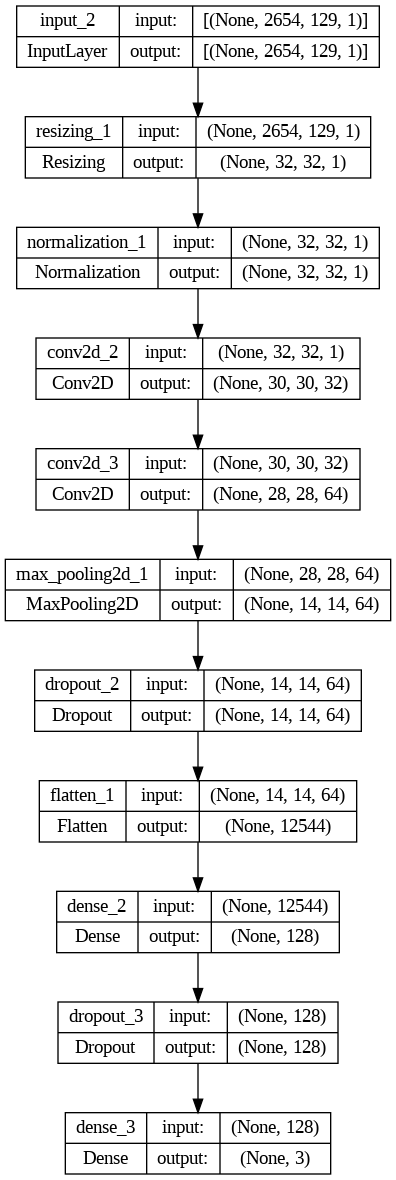

In [11]:
# Produce model summary 
train_dir = r"/content/drive/MyDrive/datasets_new_flipped"
split = '50-50'

val_data = load_audio(train_dir, split, val=True)
train_data, input_shape, num_labels = load_audio(train_dir, split, val=False)
train_model(input_shape, num_labels,train_data, val_data, summary = True)

# Run Models

Found 8968 files belonging to 3 classes.
Using 7175 files for training.
Using 1793 files for validation.
Validation dataset for 50-50
/content/drive/MyDrive/datasets_new_flipped/25-75
Found 8951 files belonging to 3 classes.
Using 7161 files for training.
Using 1790 files for validation.
Training dataset for 25-75
Epoch 1/20
224/224 [==============================] - 20s 72ms/step - loss: 1.0417 - accuracy: 0.6153 - val_loss: 0.8620 - val_accuracy: 0.6793
Epoch 2/20
224/224 [==============================] - 5s 23ms/step - loss: 0.7973 - accuracy: 0.7026 - val_loss: 0.7666 - val_accuracy: 0.7105
Epoch 3/20
224/224 [==============================] - 5s 22ms/step - loss: 0.7331 - accuracy: 0.7323 - val_loss: 0.7606 - val_accuracy: 0.7117
Epoch 4/20
224/224 [==============================] - 5s 22ms/step - loss: 0.6987 - accuracy: 0.7369 - val_loss: 0.7392 - val_accuracy: 0.7122
Epoch 5/20
224/224 [==============================] - 5s 22ms/step - loss: 0.6707 - accuracy: 0.7475 - val_loss

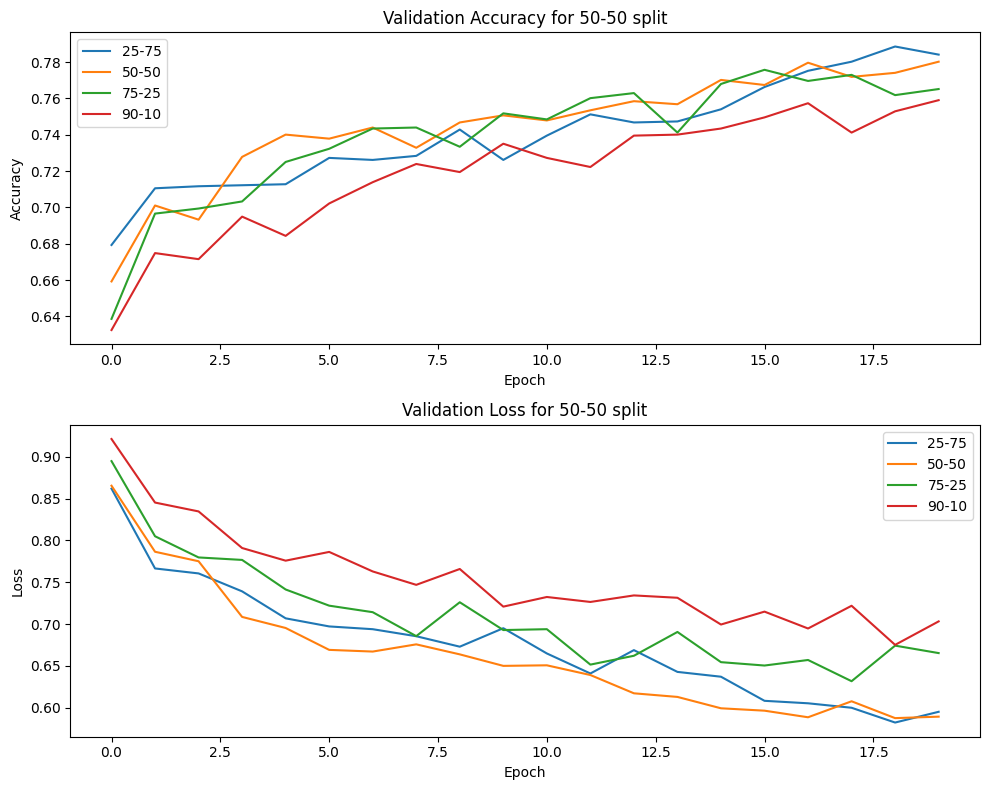

In [8]:
#train_dir = r"/content/drive/MyDrive/train_10k/"
train_dir = r"/content/drive/MyDrive/datasets_new_flipped"
output_json = r"/content/drive/MyDrive/model_json"

train_splits = ["25-75", "50-50", "75-25", "90-10"]
val_split = '50-50'
train_histories = run_model(train_splits, val_split, train_dir, output_json)


Found 8915 files belonging to 3 classes.
Using 7132 files for training.
Using 1783 files for validation.
Validation dataset for 10-90
/content/drive/MyDrive/datasets_new_flipped/10-90
Found 8915 files belonging to 3 classes.
Using 7132 files for training.
Using 1783 files for validation.
Training dataset for 10-90
Epoch 1/20
223/223 [==============================] - 175s 780ms/step - loss: 1.0025 - accuracy: 0.6322 - val_loss: 0.7761 - val_accuracy: 0.7190
Epoch 2/20
223/223 [==============================] - 5s 24ms/step - loss: 0.7410 - accuracy: 0.7389 - val_loss: 0.7428 - val_accuracy: 0.7342
Epoch 3/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6740 - accuracy: 0.7612 - val_loss: 0.6942 - val_accuracy: 0.7330
Epoch 4/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6327 - accuracy: 0.7750 - val_loss: 0.6154 - val_accuracy: 0.7779
Epoch 5/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6059 - accuracy: 0.7811 - val_lo

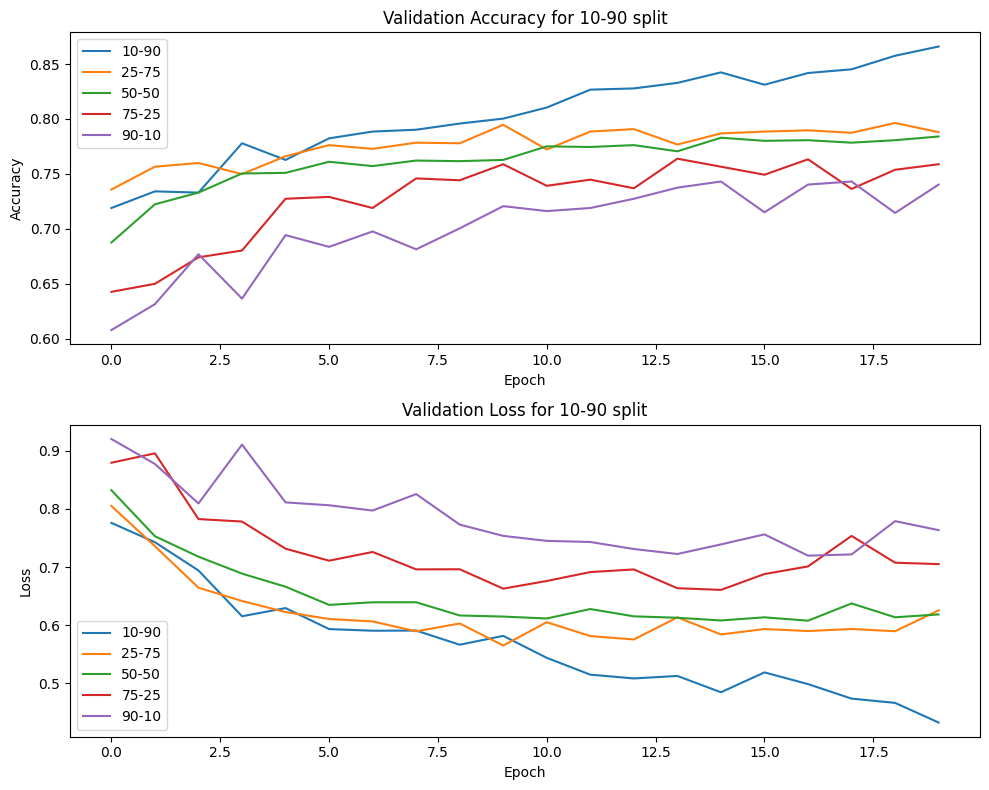

In [9]:
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
val_split = '10-90'
train_histories = run_model(train_splits, val_split, train_dir, output_json)
val_plot(val_split, train_splits, train_histories)

In [10]:
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
val_split = '25-75'
train_histories = run_model(train_splits, val_split, train_dir, output_json)

Found 8951 files belonging to 3 classes.
Using 7161 files for training.
Using 1790 files for validation.
Validation dataset for 25-75
/content/drive/MyDrive/datasets_new_flipped/10-90
Found 8915 files belonging to 3 classes.
Using 7132 files for training.
Using 1783 files for validation.
Training dataset for 10-90
Epoch 1/20
223/223 [==============================] - 175s 781ms/step - loss: 1.0220 - accuracy: 0.6211 - val_loss: 0.8325 - val_accuracy: 0.7034
Epoch 2/20
223/223 [==============================] - 6s 25ms/step - loss: 0.7386 - accuracy: 0.7393 - val_loss: 0.7322 - val_accuracy: 0.7559
Epoch 3/20
223/223 [==============================] - 5s 23ms/step - loss: 0.6729 - accuracy: 0.7590 - val_loss: 0.6762 - val_accuracy: 0.7654
Epoch 4/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6382 - accuracy: 0.7737 - val_loss: 0.6703 - val_accuracy: 0.7654
Epoch 5/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6125 - accuracy: 0.7808 - val_lo

In [11]:
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
val_split = '75-25'
train_histories = run_model(train_splits, val_split, train_dir, output_json)

Found 8968 files belonging to 3 classes.
Using 7175 files for training.
Using 1793 files for validation.
Validation dataset for 75-25
/content/drive/MyDrive/datasets_new_flipped/10-90
Found 8915 files belonging to 3 classes.
Using 7132 files for training.
Using 1783 files for validation.
Training dataset for 10-90
Epoch 1/20
223/223 [==============================] - 178s 795ms/step - loss: 1.0117 - accuracy: 0.6193 - val_loss: 1.0049 - val_accuracy: 0.5929
Epoch 2/20
223/223 [==============================] - 6s 25ms/step - loss: 0.7604 - accuracy: 0.7309 - val_loss: 0.9331 - val_accuracy: 0.6414
Epoch 3/20
223/223 [==============================] - 5s 23ms/step - loss: 0.6874 - accuracy: 0.7539 - val_loss: 0.8839 - val_accuracy: 0.6598
Epoch 4/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6521 - accuracy: 0.7635 - val_loss: 0.9586 - val_accuracy: 0.6564
Epoch 5/20
223/223 [==============================] - 5s 22ms/step - loss: 0.6220 - accuracy: 0.7780 - val_lo

In [12]:
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
val_split = '90-10'
train_histories = run_model(train_splits, val_split, train_dir, output_json)

Found 8974 files belonging to 3 classes.
Using 7180 files for training.
Using 1794 files for validation.
Validation dataset for 90-10
/content/drive/MyDrive/datasets_new_flipped/10-90
Found 8915 files belonging to 3 classes.
Using 7132 files for training.
Using 1783 files for validation.
Training dataset for 10-90
Epoch 1/20
223/223 [==============================] - 179s 798ms/step - loss: 1.0164 - accuracy: 0.6331 - val_loss: 1.0248 - val_accuracy: 0.5792
Epoch 2/20
223/223 [==============================] - 6s 25ms/step - loss: 0.7521 - accuracy: 0.7309 - val_loss: 1.0303 - val_accuracy: 0.5925
Epoch 3/20
223/223 [==============================] - 5s 23ms/step - loss: 0.6881 - accuracy: 0.7510 - val_loss: 0.9824 - val_accuracy: 0.6098
Epoch 4/20
223/223 [==============================] - 5s 23ms/step - loss: 0.6368 - accuracy: 0.7710 - val_loss: 0.9642 - val_accuracy: 0.6349
Epoch 5/20
223/223 [==============================] - 5s 23ms/step - loss: 0.6149 - accuracy: 0.7768 - val_lo